# Определение возраста покупателей с помощью нейронных сетей

<h1>Оглавление<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li><li><span><a href="#Чек-лист" data-toc-modified-id="Чек-лист-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист</a></span></li></ul></div>

## Исследовательский анализ данных

In [1]:
# Загрузим библиотеки
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [2]:
# Загрузим датасет
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


1. Датасет содержит 7591 фотографию.

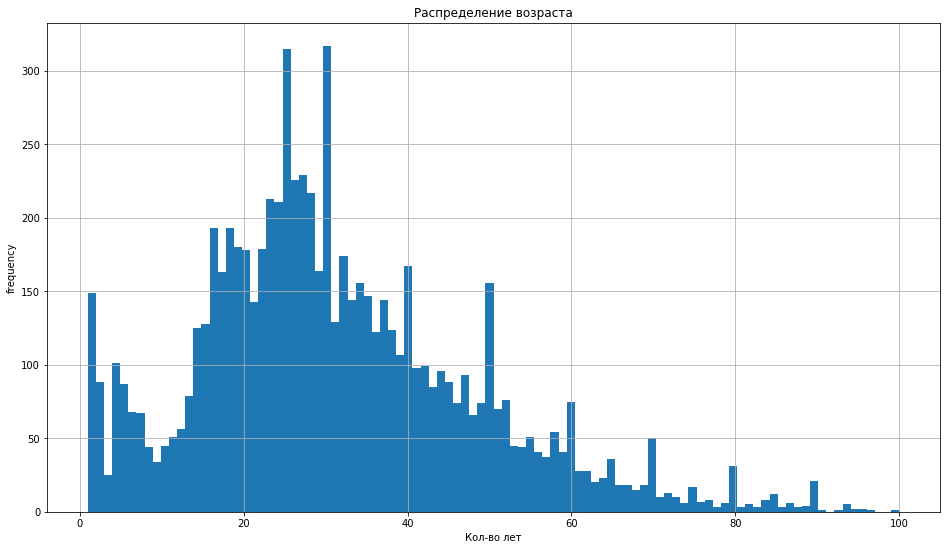

In [3]:
labels.hist(bins=100, figsize = (16,9))
plt.xlabel('Кол-во лет')
plt.ylabel('frequency')
plt.title('Распределение возраста')
plt.show()

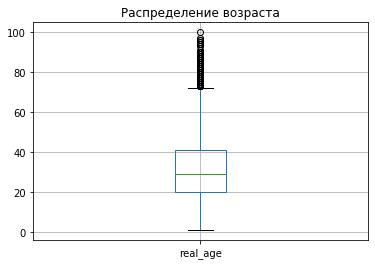

In [4]:
labels.boxplot()
plt.title('Распределение возраста')
plt.show()

In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


**Вывод**
- Данных по детям с 1-го года до 12 мало, а также они разрозненны, среднекв.отклоение 17 из-за выбросов выше 65 лет;
- Модель будет хорошо предсказывать возраст от 18 до 41 года, т.к. в этом интервале основное распределение;
- Выше 65 лет мало данных, система не обучится и будет ошибаться.

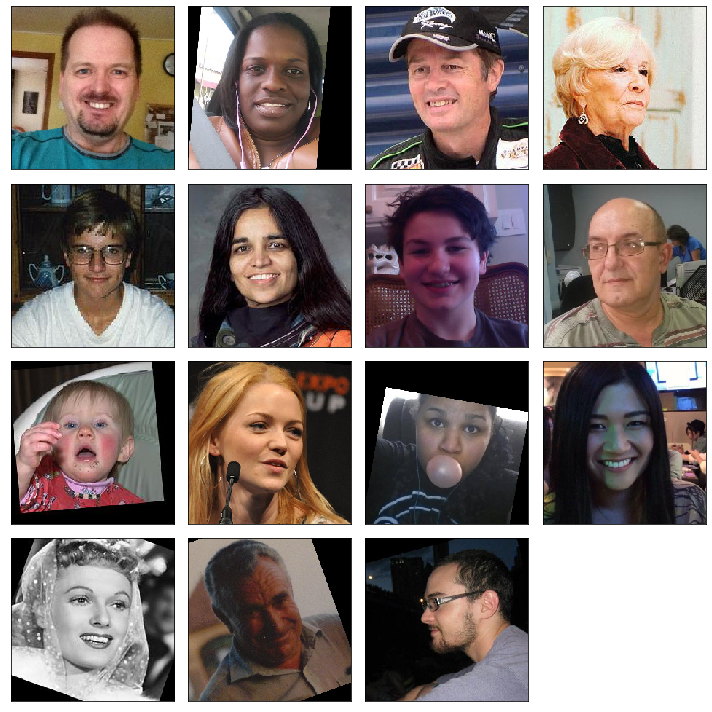

In [6]:
features, target = next(train_datagen_flow)
# выводим 15 изображений
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

In [7]:
labels.info

<bound method DataFrame.info of        file_name  real_age
0     000000.jpg         4
1     000001.jpg        18
2     000002.jpg        80
3     000003.jpg        50
4     000004.jpg        17
...          ...       ...
7586  007608.jpg        14
7587  007609.jpg        37
7588  007610.jpg        28
7589  007611.jpg        20
7590  007612.jpg        47

[7591 rows x 2 columns]>

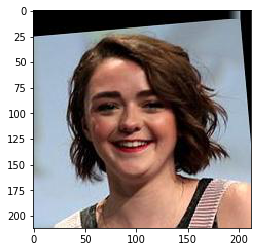

In [8]:
# На фото 17 летняя девушка, скорее всего мое MAE будет выше нейронки:)
image = Image.open('/datasets/faces/final_files/000004.jpg')
array = np.array(image)
plt.imshow(array, cmap='gray')

## Обучение модели

```python

def load_train(path):
    train_datagen = ImageDataGenerator(validation_split = 0.25, rescale=1./255)
    train_datagen_flow = train_datagen.flow_from_dataframe(
    pd.read_csv(path + 'labels.csv'), 
    path + 'final_files', 
    x_col='file_name', y_col='real_age',
    target_size=(224, 224), 
    batch_size=16, class_mode='raw', subset='training', seed=42
    )
    return train_datagen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(validation_split = 0.25, rescale=1./255)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        pd.read_csv(path + 'labels.csv'), 
        path + 'final_files', 
        x_col='file_name', y_col='real_age',
        target_size=(224, 224), 
        batch_size=16, class_mode='raw', subset='validation', seed=42
    )
    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=5,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```
Основной вывод на 5 эпохах:
Epoch 1/5
190/190 - 89s - loss: 256.2025 - mae: 11.5296 - val_loss: 936.5790 - val_mae: 25.8350
Epoch 2/5
190/190 - 81s - loss: 74.5573 - mae: 6.6400 - val_loss: 863.1633 - val_mae: 24.4203
Epoch 3/5
190/190 - 81s - loss: 44.1769 - mae: 5.1438 - val_loss: 537.5812 - val_mae: 18.1352
Epoch 4/5
190/190 - 81s - loss: 31.5399 - mae: 4.3651 - val_loss: 188.2938 - val_mae: 9.9147
Epoch 5/5
190/190 - 82s - loss: 26.1097 - mae: 3.9270 - val_loss: 90.5426 - val_mae: 7.1238

Вывод на 7 эпохах:
Epoch 1/7
190/190 - 827s - loss: 236.6960 - mae: 11.2579 - val_loss: 851.0167 - val_mae: 24.2918
Epoch 2/7
190/190 - 39s - loss: 73.8304 - mae: 6.6222 - val_loss: 526.1832 - val_mae: 17.7959
Epoch 3/7
190/190 - 40s - loss: 44.4064 - mae: 5.1498 - val_loss: 230.0642 - val_mae: 11.4669
Epoch 4/7
190/190 - 41s - loss: 33.4119 - mae: 4.4845 - val_loss: 170.1749 - val_mae: 9.8675
Epoch 5/7
190/190 - 41s - loss: 24.8778 - mae: 3.8315 - val_loss: 83.3115 - val_mae: 6.8812
Epoch 6/7
190/190 - 41s - loss: 20.6148 - mae: 3.5183 - val_loss: 90.4299 - val_mae: 7.2097
Epoch 7/7
190/190 - 41s - loss: 19.8340 - mae: 3.3822 - val_loss: 77.2415 - val_mae: 6.7217

Вывод на 5-и эпохах и bach_size = 32
Epoch 1/5
190/190 - 45s - loss: 281.7076 - mae: 12.2269 - val_loss: 1094.0973 - val_mae: 28.5896
Epoch 2/5
190/190 - 40s - loss: 71.1415 - mae: 6.4307 - val_loss: 844.9616 - val_mae: 24.1931
Epoch 3/5
190/190 - 41s - loss: 45.2768 - mae: 5.1743 - val_loss: 231.5800 - val_mae: 11.2633
Epoch 4/5
190/190 - 41s - loss: 31.0719 - mae: 4.2809 - val_loss: 125.1939 - val_mae: 8.3263
Epoch 5/5
190/190 - 41s - loss: 24.3906 - mae: 3.8404 - val_loss: 85.4020 - val_mae: 6.9290

```

## Анализ обученной модели

In [10]:
# Создадим таблицу для сравнения показателей модели
table = {'Параметры модели': ['bach_size = 16, epochs = 5', 'bach_size = 16, epochs = 7', 'bach_size = 32, epochs = 5'], 'val_score': [7.12, 6.72, 6.92]}
pivot = pd.DataFrame(data=table)
pivot

,Параметры модели,val_score
0,"bach_size = 16, epochs = 5",7.12
1,"bach_size = 16, epochs = 7",6.72
2,"bach_size = 32, epochs = 5",6.92


**Выводы**
- На входе много разных фото, отличающихся по качеству изображения, также есть монохромные фото;
- Натренерованная модель на основе "imagenet" довольно хорошо справилась с предсказанием, человек может и не справиться так хорошо; Н-р меня до сих пор в студенты записывают, хотя мне 32 года, но практически сейчас же я студент:)
- Приемлемый результат удалось достичь при lr=0.0001;
- Лучший показатель - 6.72 на 7-ой эпохе, изменения в загрузчике параметра bach_size на 32 улучшило результат на 5-ой эпохе, по сравнению с первой моделью.